In [1]:
from pyspark.sql import SparkSession

import pyspark.sql.functions as spf

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

ModuleNotFoundError: No module named 'pyspark'

In [2]:
spark = SparkSession.builder.appName("anokhin").getOrCreate()
spark

## Model Based Collaborative filtering

### Собираем данные на Spark и сохраняем как pandas dataframe

In [13]:
data = (
    spark.read.json("/user/anokhin/seminar-2/*/data.json")
#         .filter(spf.col("time") > 0.8)
        .select("user", "track", "time")
        .groupBy("user", "track")
        .agg(
            spf.avg("time").alias("time")
        )
        .withColumn("test", spf.rand() > 0.8)
)

data.limit(10).show()

+----+-----+------------------+-----+
|user|track|              time| test|
+----+-----+------------------+-----+
|8779| 9293|               1.0|false|
|5021|46804|0.6666666666666666|false|
|6980|40897|             0.045| true|
|8406|24479|              0.61|false|
|2374| 3146|               0.0|false|
|2319|22543|              0.37|false|
|8377|45742|              0.02|false|
|1249|16019|              0.01|false|
|7604| 6823|              0.13|false|
|5287| 2803|               0.4| true|
+----+-----+------------------+-----+



In [14]:
data.toPandas().to_json("/home/anokhin/week04.json", orient="records", lines=True)

### Обучаем ALS на Spark и сохраняем рекомендации

In [15]:
als = ALS(
    rank=50,
    maxIter=25, 
    regParam=0.1, 
    userCol="user", 
    itemCol="track", 
    ratingCol="time",
    coldStartStrategy="drop",
).fit(data.filter(spf.col("test") == False))

In [16]:
predictions = als.transform(data.filter(spf.col("test") == True))

predictions.show(10, False)

+----+-----+------------------+----+----------+
|user|track|time              |test|prediction|
+----+-----+------------------+----+----------+
|6958|471  |0.26              |true|0.31410235|
|2021|833  |0.3333333333333333|true|0.18633708|
|7045|1342 |0.5               |true|0.34375912|
|7833|1645 |0.53              |true|0.30532998|
|6676|1829 |0.5               |true|0.32647264|
|861 |1959 |0.3333333333333333|true|0.22080585|
|1290|1959 |0.2               |true|0.15932888|
|1323|2122 |0.0               |true|0.07266973|
|5733|2122 |1.0               |true|0.5562232 |
|1235|2142 |0.0               |true|0.17401683|
+----+-----+------------------+----+----------+
only showing top 10 rows



In [17]:
evaluator = RegressionEvaluator(
    metricName="rmse", 
    labelCol="time",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.2518213382053526


In [19]:
(
    als
        .recommendForAllUsers(100)
        .select(
            spf.col("user"),
            spf.col("recommendations.track").alias("tracks")
        )
).toPandas().to_json("/home/anokhin/recomendations_als.json", orient="records", lines=True)

### Train LightFM

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.special as sp

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [10]:
full_data = pd.read_json("/Users/n.anokhin/Desktop/week04.json", lines=True)

data = full_data[full_data["time"] > 0.5]

data.head()

,user,track,time,test
0,3539,11995,0.59,False
22,4055,8027,0.80,False
26,3172,38209,1.00,False
28,5463,11790,0.64,False
29,757,18718,1.00,True


In [11]:
user_counts = data.loc[~data["test"], "user"].value_counts()
users = set(user_counts[user_counts >= 5].index.values)

len(users)

6642

In [12]:
track_counts = data.loc[~data["test"], "track"].value_counts()
tracks = set(track_counts[track_counts >= 5].index.values)

len(tracks)

2742

In [23]:
train_data = data[~data["test"] & data["user"].isin(users) & data["track"].isin(tracks)]
test_data = full_data[full_data["test"] & full_data["user"].isin(users) & full_data["track"].isin(tracks)]

len(train_data), len(test_data)

(15089, 4629)

In [24]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [25]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [17]:
def fit_model(epochs=1, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=user_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=1, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [18]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
best_params = study.best_params

best_params

[I 2024-10-10 10:41:58,848] A new study created in memory with name: no-name-1d90968c-687f-4248-b94c-2a0c34d8b504
[I 2024-10-10 10:41:59,142] Trial 0 finished with value: 0.0018629806581884623 and parameters: {'loss': 'warp', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.001}. Best is trial 0 with value: 0.0018629806581884623.
[I 2024-10-10 10:41:59,385] Trial 1 finished with value: 0.002043269108980894 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 10, 'user_alpha': 0.01, 'item_alpha': 0.01}. Best is trial 1 with value: 0.002043269108980894.
[I 2024-10-10 10:41:59,614] Trial 2 finished with value: 0.0009014423121698201 and parameters: {'loss': 'bpr', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.001, 'item_alpha': 0.001}. Best is trial 1 with value: 0.002043269108980894.
[I 2024-10-10 10:41:59,896] Trial 3 finished with value: 0.002163461409509182 and param

{'loss': 'warp',
 'no_components': 30,
 'learning_rate': 0.01,
 'max_sampled': 20,
 'user_alpha': 0.0,
 'item_alpha': 0.01}

In [19]:
best_params = {
    'loss': 'warp',
    'no_components': 50,
    'learning_rate': 0.01,
    'max_sampled': 100,
    'user_alpha': 0.0,
    'item_alpha': 0.01
}

In [20]:
model, precisions_at = fit_model(
    epochs=100,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.0012620191555470228 +/- 0.0005365189523513898
1:	0.0014423077227547765 +/- 0.0005730390529280436
2:	0.0016225961735472083 +/- 0.0006072435024832864
3:	0.001983173191547394 +/- 0.0006701015156348574
4:	0.002343749860301614 +/- 0.0007271359000553197
5:	0.002343749860301614 +/- 0.0007271359000553197
6:	0.0024038460105657578 +/- 0.000736172657911059
7:	0.003004807746037841 +/- 0.0008372760095128142
8:	0.003665865631774068 +/- 0.0009334434552899065
9:	0.0045072115026414394 +/- 0.0010644628182466676
10:	0.006129808258265257 +/- 0.0012116258684007738
11:	0.007752403616905212 +/- 0.001379090109522366
12:	0.009194711223244667 +/- 0.0015039611925893195
13:	0.010637019760906696 +/- 0.00160764819463212
14:	0.01250000111758709 +/- 0.0017316501702139952
15:	0.013581732288002968 +/- 0.001791950889855255
16:	0.015024038031697273 +/- 0.00187202780978256
17:	0.016346154734492302 +/- 0.00192719819089281
18:	0.017307693138718605 +/- 0.0019861410587408857
19:	0.018689902499318123 +/- 0.002050522672533

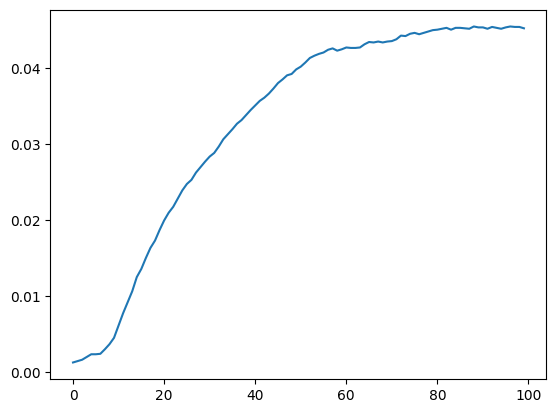

In [21]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

In [26]:
predictions = model.predict(
    test_data["user"].map(dataset.mapping()[0]).values,
    test_data["track"].map(dataset.mapping()[2]).values,
)

rmse = np.sqrt(((predictions - test_data["time"].values) * (predictions - test_data["time"].values)).mean())
rmse # Q: ???

0.6639408186480767

## Save track embeddings

In [27]:
BOTIFY_DATA_DIR = "/Users/n.anokhin/Projects/recsys-course/botify/data/"

In [28]:
biases, embeddings = model.get_item_representations()

In [29]:
track_meta = pd.read_json(BOTIFY_DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [30]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [31]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir="/Users/n.anokhin/Desktop/tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [32]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [33]:
predictions = model.predict(1, np.arange(dataset.item_features_shape()[0]), num_threads=30)
predictions

array([-0.255514  , -0.3594906 ,  0.04824547, ..., -0.39435065,
       -0.5408309 , -0.10414219], dtype=float32)

In [34]:
with open(BOTIFY_DATA_DIR + "recommendations_lfm.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": top.tolist()
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6642/6642 [00:03<00:00, 2101.17it/s]
